# Regionalizing Prague Regions

**Regionalization** is a clustering technique that groups spatial items having areal representations into homogenous continuous regions. A reasonable assumption in cities is that the contiguous subregions can be regionalized into spatial communities (clusters). Such a task can assist providers in various complex problems, such as picking warehouse locations, producing effective geo-marketing campaigns, and producing fair geo-based policies. In this final project, we aim to investigate methods that take into account the place of subregions and use spatial information to create spatial clusters. 

To better understand the task, consider the following map of Prague:

![invalidRegionalization.png](mapPrague.png)

A *valid* regionalization output can be seen bellow. Note that the three clusters are contiguous. It means that if a subregion $x_i$ belongs to the region $R_k$, at least one subregion $x_j \in R_k$ shares a border with x_i.

![invalidRegionalization.png](validRegionalization.png)

 However, the partition bellow is not a valid regionalization. The reason is that one can find a subregion of $R_3$ that does not connect to any subregion of $R_3$.

![invalidRegionalization.png](invalidRegionalization.png)

# Final Project (16 points)

The final project is a group project. The main task is to cluster the Prague map into $k$ regions respecting regionalization constraints. Your group needs to:

* Develop a **new** learning algorithm for regionalizing maps.
* Run your algorithm and compare it with **at least** one baseline (you must research at least one baseline).
* Choose the *best* value of $k$ under some assumption (e.g. elbow rule)
* Find anomalous subregions inside the clusters.
* Make a report that describes the method and engineering decisions (max three pages).
* Produce a blog post that explains your method for a broad audience (you do not need to publish it).
* You must present your solution in the form of a business presentation to sell your solution would be the best way to regionalize Prague.

Obs.: A cluster must contain at least $10$ subregions

Note that I am not constraining the project. For example, I am not defining the metrics you should use. However, I expect the justification for project decisions in both the report and the presentation.

In [1]:
import numpy as np
import math
import geopandas
import pandas as pd

In [2]:
#Open Geographic Information
gdf = geopandas.read_file("MAP_MESTSKECASTI_P.shp")
gdf['ID'] = gdf['ID'].astype(int)
gdf['geometry'].head()
gdf

,DAT_VZNIK,DAT_ZMENA,PLOCHA,ID,KOD_MC,NAZEV_MC,KOD_MO,KOD_SO,TID_TMMEST,POSKYT,ID_POSKYT,STAV_ZMENA,NAZEV_1,Shape_Leng,Shape_Area,geometry
0,2018-11-06,2021-12-07,10183715.62,25,547310,Praha-Čakovice,94,221,25,HMP-IPR,43,U,Čakovice,18510.070836,1.018372e+07,"POLYGON ((-733164.100 -1037426.870, -733137.03..."
1,2017-11-10,2022-04-05,13529637.10,9,547361,Praha 14,94,141,9,HMP-IPR,43,U,Praha 14,21694.540692,1.352964e+07,"POLYGON ((-732843.230 -1045666.050, -732873.05..."
2,2018-10-09,2022-08-03,23317908.20,4,547107,Praha 12,43,124,4,HMP-IPR,43,U,Praha 12,28249.410338,2.331791e+07,"POLYGON ((-741841.950 -1052678.550, -741838.85..."
3,2018-11-06,2022-02-16,3253142.38,52,547174,Praha 17,60,213,52,HMP-IPR,43,U,Praha 17,7936.181054,3.253142e+06,"POLYGON ((-752038.720 -1042852.140, -752039.50..."
4,2016-04-22,2021-11-16,7379375.19,23,547298,Praha-Ďáblice,86,86,23,HMP-IPR,43,U,Ďáblice,14957.952940,7.379375e+06,"POLYGON ((-739567.300 -1037894.610, -739567.00..."
5,2018-12-04,2022-06-03,18599770.16,6,500224,Praha 10,108,108,6,HMP-IPR,43,U,Praha 10,27422.472988,1.859977e+07,"POLYGON ((-737686.380 -1048543.340, -737697.85..."
6,2018-10-09,2022-08-03,5001768.34,45,539724,Praha-Šeberov,43,116,45,HMP-IPR,43,U,Šeberov,12935.445690,5.001768e+06,"POLYGON ((-735846.100 -1052465.110, -735861.66..."
7,2016-04-22,2022-07-07,4988872.84,46,547301,Praha-Dolní Chabry,86,86,46,HMP-IPR,43,U,Dolní Chabry,12378.929986,4.988873e+06,"POLYGON ((-740065.330 -1038014.670, -740069.09..."
8,2018-06-13,2021-11-16,1786429.22,57,547395,Praha-Petrovice,108,159,57,HMP-IPR,43,U,Petrovice,7428.820315,1.786429e+06,"POLYGON ((-734630.210 -1050860.340, -734629.87..."
9,2018-12-04,2021-12-07,6482054.69,38,500097,Praha 3,35,35,38,HMP-IPR,43,U,Praha 3,13398.386084,6.482055e+06,"POLYGON ((-739419.400 -1042829.380, -739377.10..."


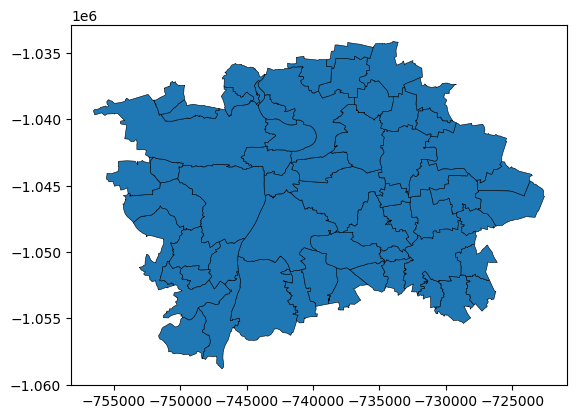

In [3]:
#Printing a map
gdf['cluster']=np.zeros(gdf['ID'].shape[0])
regions = gdf.plot(column='cluster', linewidth=0.4, edgecolor='black', legend=False, categorical=True)

In [4]:
def connectionGraph(gdf):
    graph = {}
    for index, row in gdf.iterrows():
        neighbors = gdf[~gdf.geometry.disjoint(row.geometry)].ID.tolist()
        neighbors = [n_id for n_id in neighbors if row.ID != n_id]
        graph[row.ID] = neighbors
    return graph

graph = connectionGraph(gdf)

<Axes: >

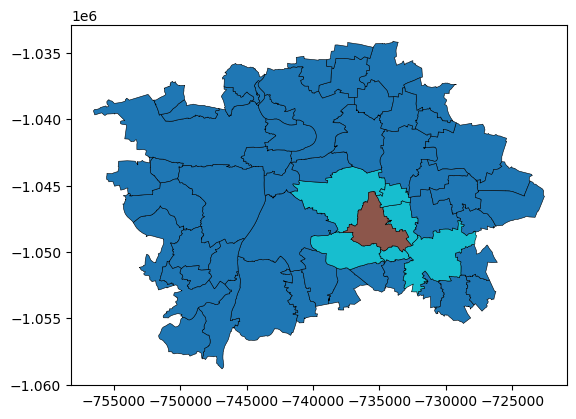

In [5]:
gdf['cluster']=np.zeros(gdf['ID'].shape[0]) #show all neighbours of brown neighbourhood
subreg = 12
gdf.loc[gdf['ID']==subreg,'cluster'] = 1
for neighbor in graph[subreg]:
    gdf.loc[gdf['ID']==neighbor,'cluster'] = 2
    
gdf.plot(column='cluster', linewidth=0.4, edgecolor='black', legend=False, categorical=True)

The regionalization must be done according to the demographic values represented by the following dataframe

In [6]:
df=pd.read_csv('pragueFeatures.csv')
df

,ID,Feature_1,Feature_2,Feature_3,Feature_4
0,25,-0.242001,-0.199829,-2.444677,0.558649
1,9,2.058356,-0.550588,-1.992667,-0.287513
2,4,0.022728,-0.399645,-2.061011,0.429079
3,52,2.237722,0.858906,0.293994,-1.890483
4,23,1.121568,-0.433501,-2.399417,-0.102562
5,6,0.039704,0.240612,-2.736600,2.017571
6,45,0.180722,1.164965,-1.866302,1.595274
7,46,2.062138,0.050798,0.206467,-1.705487
8,57,0.009476,-0.677654,-2.564272,2.329335
9,38,2.012007,0.260663,0.084743,-1.384562


In [7]:
from sklearn import datasets
from sklearn.cluster import KMeans
from collections import Counter
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import linkage
import matplotlib.pyplot as plt
import matplotlib
import geopandas
import pandas as pd
import numpy 


%matplotlib inline

gdf = geopandas.read_file("MAP_MESTSKECASTI_P.shp")
gdf['ID'] = gdf['ID'].astype(int)
df=pd.read_csv('pragueFeatures.csv')

def connectionGraph(gdf):
    graph = {}
    for index, row in gdf.iterrows():
        neighbors = gdf[~gdf.geometry.disjoint(row.geometry)].ID.tolist()
        neighbors = [n_id for n_id in neighbors if row.ID != n_id]
        graph[row.ID] = neighbors
    return graph

graph = connectionGraph(gdf)



/home/dr_aleksan/.local/lib/python3.8/site-packages/spopt/region/skater.py:537: OptimizeWarning: MSF contains no valid moves after finding 4 subtrees. Decrease the size of your quorum to find the remaining 1 subtrees.
  model.fit(


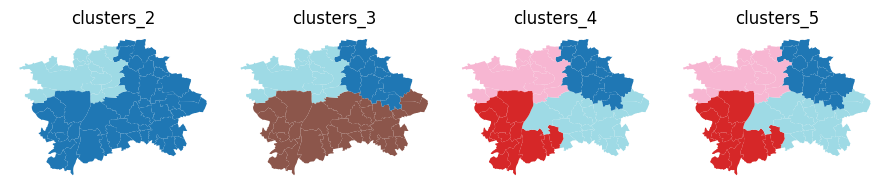

In [8]:
import libpysal
import geopandas
import libpysal
import matplotlib.pyplot as plt
import numpy
import pandas
import shapely
from sklearn.metrics import pairwise as skm
import spopt
import warnings
# Merge the two dataframes based on the 'ID' column
data = gdf.merge(df, on='ID')

attrs_name = [
    "Feature_1",
    "Feature_2",
    "Feature_3",
    "Feature_4"
]
#Not all values are available in all communities for each variable, so we’ll set those to 0.
for i in attrs_name:
    data[i] = data[i].fillna(0)

n_clusters_range = [2, 3, 4, 5]

floor, trace, islands = 10, True, "increase"
spanning_forest_kwds = dict(
    dissimilarity=skm.manhattan_distances,
    affinity=None,
    reduction=numpy.sum,
    center=numpy.mean,
    verbose=False
)

w = libpysal.weights.Queen.from_dataframe(data, use_index=False)


for ncluster in n_clusters_range:
    model = spopt.region.Skater(
        data,
        w,
        attrs_name,
        n_clusters=ncluster,
        floor=floor,
        trace=trace,
        islands=islands,
        spanning_forest_kwds=spanning_forest_kwds
    )
    model.solve()
    data[f"clusters_{ncluster}"] = model.labels_

f, axarr = plt.subplots(1, len(n_clusters_range), figsize=(9, 7.5))
for ix, clust in enumerate(n_clusters_range):
    label = f"clusters_{clust}"
    data.plot(column=label, ax=axarr[ix], cmap="tab20")
    axarr[ix].set_title(label)
    axarr[ix].set_axis_off()
plt.subplots_adjust(wspace=1, hspace=0.5)
plt.tight_layout()


In [9]:
import sklearn
from sklearn.cluster import KMeans

data = gdf.merge(df, on='ID')

# List of columns to be removed
columns_to_remove = ['DAT_VZNIK', 'DAT_ZMENA', 'POSKYT', 'ID_POSKYT', 'STAV_ZMENA', 'TID_TMMEST', 'KOD_MO', 'KOD_SO']
# Drop the specified columns
data = data.drop(columns=columns_to_remove)

# Select columns for clustering
columns_for_clustering = ['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4']

# Extract the selected columns for clustering
cluster_data = data[columns_for_clustering]

#TODO research best normalization
# Standardize and normalize the data
normalized_data = (cluster_data - cluster_data.mean()) / cluster_data.std()


# Set the number of clusters (you can adjust this based on your preferences)
num_clusters = 3

# Perform KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
data['Cluster'] = kmeans.fit_predict(normalized_data)

graph = connectionGraph(gdf)
data

,PLOCHA,ID,KOD_MC,NAZEV_MC,NAZEV_1,Shape_Leng,Shape_Area,geometry,Feature_1,Feature_2,Feature_3,Feature_4,Cluster
0,10183715.62,25,547310,Praha-Čakovice,Čakovice,18510.070836,1.018372e+07,"POLYGON ((-733164.100 -1037426.870, -733137.03...",-0.242001,-0.199829,-2.444677,0.558649,2
1,13529637.10,9,547361,Praha 14,Praha 14,21694.540692,1.352964e+07,"POLYGON ((-732843.230 -1045666.050, -732873.05...",2.058356,-0.550588,-1.992667,-0.287513,2
2,23317908.20,4,547107,Praha 12,Praha 12,28249.410338,2.331791e+07,"POLYGON ((-741841.950 -1052678.550, -741838.85...",0.022728,-0.399645,-2.061011,0.429079,2
3,3253142.38,52,547174,Praha 17,Praha 17,7936.181054,3.253142e+06,"POLYGON ((-752038.720 -1042852.140, -752039.50...",2.237722,0.858906,0.293994,-1.890483,1
4,7379375.19,23,547298,Praha-Ďáblice,Ďáblice,14957.952940,7.379375e+06,"POLYGON ((-739567.300 -1037894.610, -739567.00...",1.121568,-0.433501,-2.399417,-0.102562,2
5,18599770.16,6,500224,Praha 10,Praha 10,27422.472988,1.859977e+07,"POLYGON ((-737686.380 -1048543.340, -737697.85...",0.039704,0.240612,-2.736600,2.017571,0
6,5001768.34,45,539724,Praha-Šeberov,Šeberov,12935.445690,5.001768e+06,"POLYGON ((-735846.100 -1052465.110, -735861.66...",0.180722,1.164965,-1.866302,1.595274,0
7,4988872.84,46,547301,Praha-Dolní Chabry,Dolní Chabry,12378.929986,4.988873e+06,"POLYGON ((-740065.330 -1038014.670, -740069.09...",2.062138,0.050798,0.206467,-1.705487,1
8,1786429.22,57,547395,Praha-Petrovice,Petrovice,7428.820315,1.786429e+06,"POLYGON ((-734630.210 -1050860.340, -734629.87...",0.009476,-0.677654,-2.564272,2.329335,2
9,6482054.69,38,500097,Praha 3,Praha 3,13398.386084,6.482055e+06,"POLYGON ((-739419.400 -1042829.380, -739377.10...",2.012007,0.260663,0.084743,-1.384562,1


In [13]:
from collections import deque

#define the cluster_table
cluster_table = data[['ID', 'Cluster']].set_index('ID')
cluster_table

def largest_connected_components(cluster_table, graph):
    largest_connected = {}  # Dictionary to store largest connected components for each cluster

    for cluster in cluster_table['Cluster'].unique():
        # Filter data for the current cluster
        cluster_data = cluster_table[cluster_table['Cluster'] == cluster]
        
        largest_size = 0
        largest_connected[cluster] = set()

        for region_id in cluster_data.index:
            if region_id not in largest_connected[cluster]:
                # Perform BFS to find connected components
                connected_component = bfs(region_id, cluster, graph, cluster_table)
                
                # Update largest connected component if the current one is larger
                if len(connected_component) > largest_size:
                    largest_size = len(connected_component)
                    largest_connected[cluster] = connected_component

    return largest_connected

def bfs(start_node, cluster, graph, cluster_table):
    visited = set()
    connected_component = set()

    queue = deque([start_node])
    visited.add(start_node)

    while queue:
        current_node = queue.popleft()
        connected_component.add(current_node)

        # Explore neighbors belonging to the same cluster
        neighbors = [neighbor for neighbor in graph[current_node] if cluster_table.at[neighbor, 'Cluster'] == cluster]
        for neighbor in neighbors:
            if neighbor not in visited:
                queue.append(neighbor)
                visited.add(neighbor)

    return connected_component

# Example usage
largest_connected = largest_connected_components(cluster_table, graph)
print("Largest Connected Components:")
largest_connected

Largest Connected Components:


{2: {7, 9, 10, 21, 23, 25, 26, 32, 35, 37, 40, 41, 42},
 1: {1, 5, 17, 24, 30, 38, 43, 44, 46, 48, 50, 51, 52, 56},
 0: {3, 6, 12, 14, 15, 20, 27, 28, 33, 34, 36, 39, 45, 49, 53}}

In [38]:
from scipy.spatial.distance import euclidean
#undefined_points = [point for point in data['ID'] if point not in set.union(*largest_connected.values())]
#undefined_points

def enlarge_connected_components(largest_connected, cluster_table, data, graph, min_size=10):
    
    # Extract points not part of any largest connected component 
    undefined_points = [point for point in data['ID'] if point not in set.union(*largest_connected.values())]

    # Iterate through the largest connected components
    for cluster, connected_component in largest_connected.items():
        if len(connected_component) < min_size:
            # Find the centroid of the connected component
            centroid = calculate_centroid(data, connected_component)
            
            # Sort undefined points based on their distances to the centroid
            sorted_points = sort_points_by_distance(data, undefined_points, centroid)

            print(connected_component)
            # Add points to the connected component until it reaches the minimum size
            enlarge_connected_component(connected_component, sorted_points, graph, min_size, cluster_table, data)
            print(connected_component)


def calculate_centroid(data, points):
    # Calculate the centroid based on Feature values
    centroid = data[data['ID'].isin(points)][['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4']].mean()
    return centroid

def sort_points_by_distance(data, points, centroid):
    # Sort points based on their distances to the centroid
    sorted_points = sorted(points, key=lambda point: euclidean(data[data['ID'] == point][['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4']].values.flatten(), centroid.values.flatten()))
    return sorted_points

def enlarge_connected_component(connected_component, sorted_points, graph, min_size, cluster_table, data):
    while len(connected_component) < min_size and sorted_points:
        # Add the closest point to the connected component
        closest_point = sorted_points.pop(0)

        # Check if the closest point has a connection with the connected component
        if any(neighbor in connected_component for neighbor in graph[closest_point]):
            print(graph[closest_point])
            connected_component.add(closest_point)
            # Update cluster information in cluster_table
            cluster_table.at[data[data['ID'] == closest_point].index[0], 'Cluster'] = cluster_table.loc[connected_component[0], 'Cluster']

# Example usage
enlarge_connected_components(largest_connected, cluster_table, data, graph, min_size = 10)
largest_connected
cluster_table['Cluster']


ID
25    2
9     2
4     2
52    1
23    2
6     0
45    0
46    1
57    2
38    1
13    2
43    1
1     1
10    2
44    1
20    0
34    0
19    2
35    2
30    1
11    2
29    2
22    2
54    0
42    2
18    0
15    0
14    0
12    0
3     0
2     2
7     2
49    0
50    1
24    1
26    2
55    2
48    1
40    2
33    0
31    0
53    0
27    0
51    1
47    2
56    1
39    0
41    2
32    2
28    0
5     1
8     1
17    1
16    2
21    2
36    0
37    2
Name: Cluster, dtype: int32